In [9]:
!pip install mlxtend
!pip install onnxmltools
!pip install onnxruntime

In [1]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination
from sklearn.metrics import r2_score

In [3]:
import xgboost as xgb

In [106]:
!pip install skl2onnx

In [4]:
import onnxruntime as rt
import onnxmltools

from skl2onnx.common.data_types import FloatTensorType

In [5]:
## 0.001, 0.0001, 0.0003, 0.01, 0.03

batch_size    = 16
learning_rate = 0.001 # or 0.0005
N_Epochs      = 100

epsilon = 0.0001

In [6]:
path_data = '/content/drive/MyDrive/digital_habits_vs_mental_health.csv'

IMH_raw_data = pd.read_csv( path_data, delimiter=";" )
IMH_raw_data = pd.read_csv ( path_data, sep=",")

In [7]:
IMH_raw_data

,screen_time_hours,social_media_platforms_used,hours_on_TikTok,sleep_hours,stress_level,mood_score
0,10.3,2,5.3,4.4,10,5
1,6.5,5,3.5,6.2,8,8
2,9.1,4,2.8,6.6,7,8
3,6.5,3,2.5,6.5,7,9
4,2.1,3,1.2,7.8,2,10
...,...,...,...,...,...,...
99995,5.0,4,1.8,4.5,10,9
99996,6.4,3,3.1,5.4,10,5
99997,3.7,3,1.5,8.3,4,10
99998,10.6,2,5.3,7.2,9,9


In [8]:
headers_list = IMH_raw_data.columns.values.tolist()

headers_list

['screen_time_hours',
 'social_media_platforms_used',
 'hours_on_TikTok',
 'sleep_hours',
 'stress_level',
 'mood_score']

In [9]:
headers_list2 = [ 'screen_time_hours',
 'social_media_platforms_used',
 'hours_on_TikTok',
 'sleep_hours',
 'stress_level','mood_score']

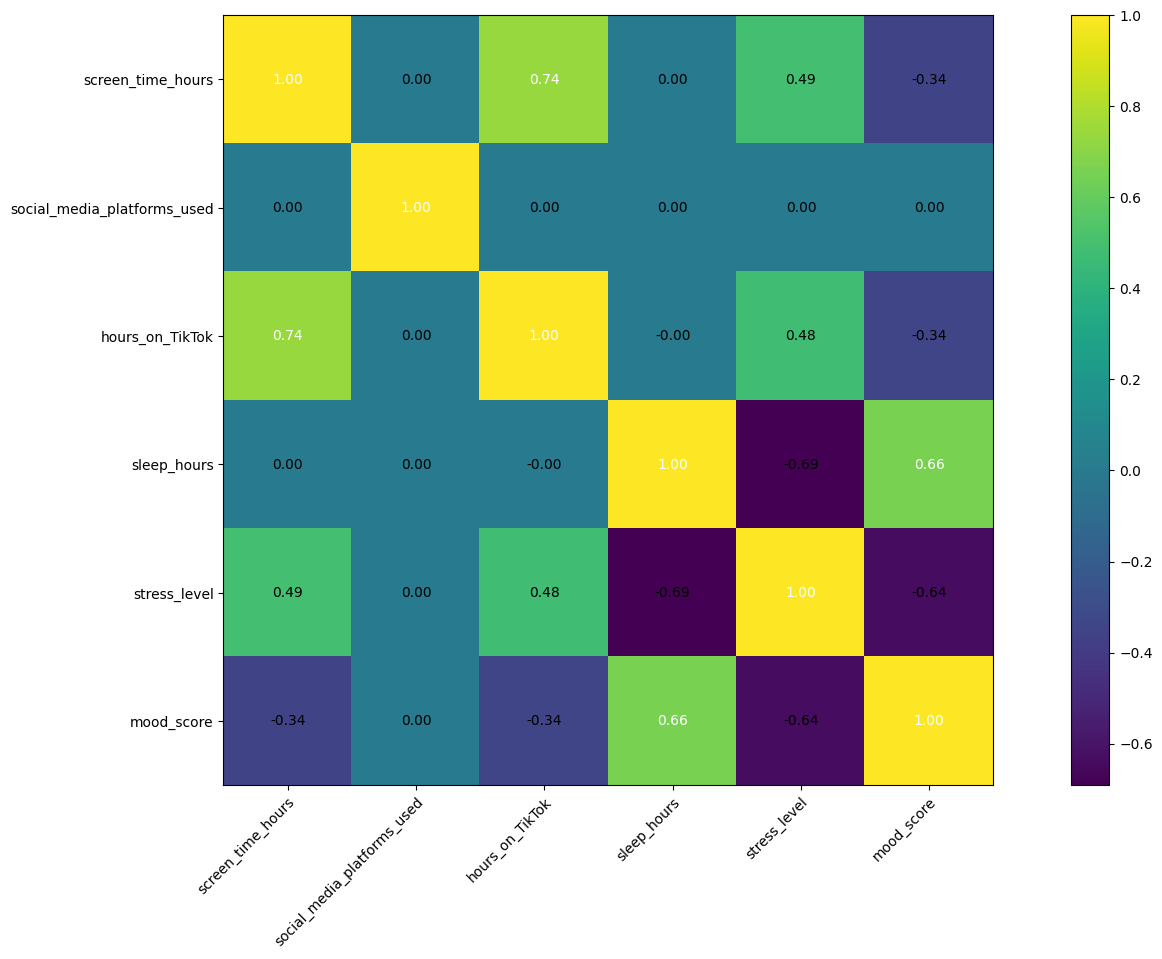

In [10]:
cm = np.corrcoef(   IMH_raw_data[headers_list].values.T   )
hm = heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
plt.show()

In [11]:
## Convert Pandas to Numpy

IMH_raw_data_np = IMH_raw_data.to_numpy()

In [12]:
IMH_raw_data_np

array([[10.3,  2. ,  5.3,  4.4, 10. ,  5. ],
       [ 6.5,  5. ,  3.5,  6.2,  8. ,  8. ],
       [ 9.1,  4. ,  2.8,  6.6,  7. ,  8. ],
       ...,
       [ 3.7,  3. ,  1.5,  8.3,  4. , 10. ],
       [10.6,  2. ,  5.3,  7.2,  9. ,  9. ],
       [ 5.4,  4. ,  2.2,  7.4,  5. , 10. ]])

In [13]:
IMH_raw_data_np.shape

(100000, 6)

In [14]:
X = IMH_raw_data_np[:, :-1]


y = IMH_raw_data_np[:, 5:6]

In [15]:
y

array([[ 5.],
       [ 8.],
       [ 8.],
       ...,
       [10.],
       [ 9.],
       [10.]])

In [16]:
print(X.shape)

print(y.shape)

(100000, 5)
(100000, 1)


In [17]:
random_seed = int( random.random() * 100 )

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 5)
(20000, 5)
(80000, 1)
(20000, 1)


In [20]:
y_test.dtype

dtype('float64')

In [21]:
## fix data type

X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )
y_train = y_train.astype(  np.float32  )
y_test  = y_test.astype(   np.float32  )

In [22]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr  = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr  = torch.from_numpy(y_test)

In [23]:
x_means      = X_train_tr.mean(0, keepdim=True )

x_deviations = X_train_tr.std( 0, keepdim=True) + epsilon

In [24]:
x_means

tensor([[6.0034, 2.9955, 2.4012, 6.9874, 6.1801]])

In [25]:
x_deviations

tensor([[1.9872, 1.4134, 1.0786, 1.4636, 2.0455]])

In [26]:
train_ds = TensorDataset( X_train_tr, y_train_tr  )

In [27]:
train_dl = DataLoader( train_ds, batch_size, shuffle=True  )

In [28]:
train_dl

In [29]:
## Linear Regression

class LinRegNet(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(5, 1)

    ## perform inference
    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        y_pred = self.linear1(x)
        ## return torch.round( y_pred )
        return y_pred


In [30]:
## MLP

class MLP_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(5, 4)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(4, 1)
    ## perform inference
    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        x = self.linear1(x)
        x = self.act1(x)
        y_pred = self.linear2(x)

        ## return torch.round( y_pred )
        return y_pred

In [31]:
## Deep Learning with 2 hidden layers

class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(5, 4)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(4, 2)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(2, 1)
    ## perform inference
    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        y_pred = self.linear3(x)

        ## return torch.round( y_pred )
        return y_pred

In [32]:
## Linear plus Nonlinear
## f1 + f2

class LinearPlusNonLinear_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()

        self.x_means      = x_means
        self.x_deviations = x_deviations

        ## F1
        self.f1_linear1 = nn.Linear(5, 1)

        ## F2
        self.f2_linear1 = nn.Linear(5, 8)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(8, 1)


    ## perform inference
    def forward(self, x):

        x = (x - self.x_means) / self.x_deviations

        ## F1
        f1 = self.f1_linear(x)

        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)

        y_pred = f1 + f2

        ## return torch.round( y_pred )
        return y_pred

In [33]:
def training_loop( N_Epochs, model, loss_fn, opt  ):

    for epoch in range(N_Epochs):
        for xb, yb in train_dl:

            y_pred = model(xb)
            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            print(epoch, "loss=", loss)

In [34]:
## model = LinRegNet( x_means, x_deviations  )
model = DL_Net( x_means, x_deviations  )

opt     = torch.optim.Adam(    model.parameters(), lr=learning_rate )
loss_fn = F.mse_loss

training_loop(  N_Epochs, model, loss_fn, opt  )

0 loss= tensor(23.2435, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 13.1 MB/s eta 0:00:00
Starting training...
Epoch 0/100 - Loss: 7.481545
Epoch 10/100 - Loss: 0.548124
Epoch 20/100 - Loss: 0.548980
Epoch 30/100 - Loss: 0.548474
Epoch 40/100 - Loss: 0.548229
Epoch 50/100 - Loss: 0.548151
Epoch 60/100 - Loss: 0.547885
Epoch 70/100 - Loss: 0.548170
Epoch 80/100 - Loss: 0.547778
Epoch 90/100 - Loss: 0.547738
Epoch 99/100 - Loss: 0.547477
Training completed!


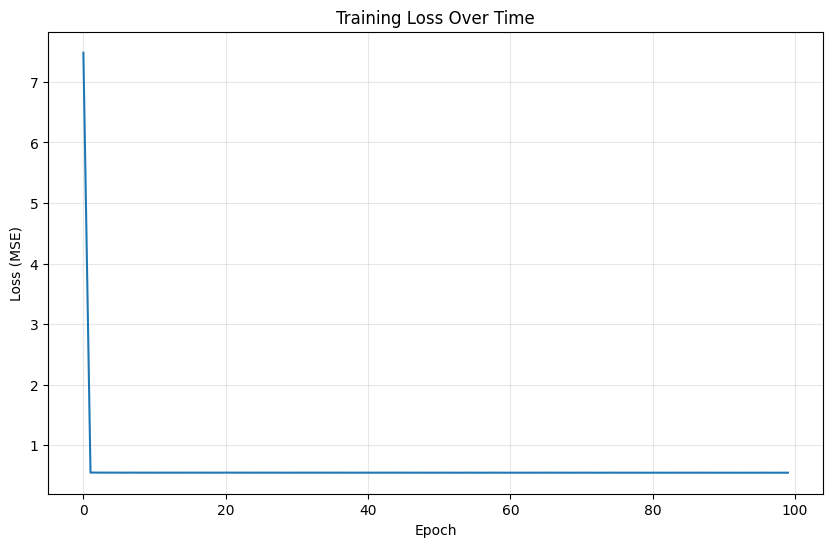


=== Final Results ===
Final Training Loss: 0.547477
Test Loss (MSE): 0.547079
Test RMSE: 0.7396
R² Score: 0.6609


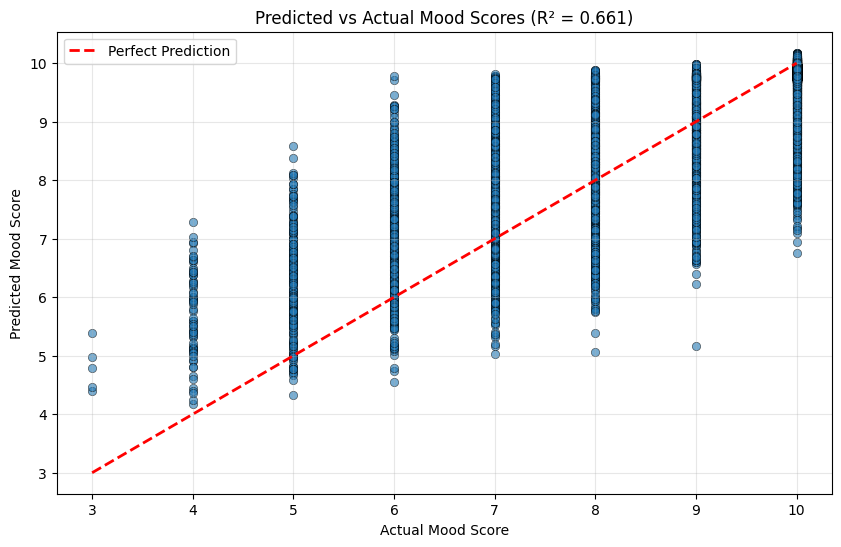

/tmp/ipython-input-1372926472.py:91: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1218 17:16:50.187000 653 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `DL_Net([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DL_Net([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/BaseConverter.h:68: adapter_lookup: Assertion `false`

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅

Model exported to: /content/drive/MyDrive/mood_prediction_model.onnx
PyTorch model saved to: /content/drive/MyDrive/mood_model.pth


In [138]:
# Install missing dependency (run this first!)
!pip install onnxscript

# Improved training loop with better progress tracking

def training_loop_improved(N_Epochs, model, loss_fn, opt):
    loss_history = []

    print("Starting training...")
    for epoch in range(N_Epochs):
        epoch_loss = 0
        batch_count = 0

        for xb, yb in train_dl:
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
            batch_count += 1

        # Calculate average loss for this epoch
        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)

        # Print progress more frequently
        if epoch % 10 == 0 or epoch == N_Epochs - 1:
            print(f"Epoch {epoch}/{N_Epochs} - Loss: {avg_loss:.6f}")

    print("Training completed!")
    return loss_history

# Re-initialize the model
model = DL_Net(x_means, x_deviations)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

# Train with improved tracking
loss_history = training_loop_improved(N_Epochs, model, loss_fn, opt)

# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Time')
plt.grid(True, alpha=0.3)
plt.show()

# Now evaluate on test set
model.eval()

with torch.no_grad():
    # Make predictions on test set
    y_pred_test = model(X_test_tr)

    # Calculate test loss
    test_loss = F.mse_loss(y_pred_test, y_test_tr)

    # Calculate R² score
    y_pred_np = y_pred_test.numpy()
    y_test_np = y_test_tr.numpy()
    r2 = r2_score(y_test_np, y_pred_np)

    print(f"\n=== Final Results ===")
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Test Loss (MSE): {test_loss.item():.6f}")
    print(f"Test RMSE: {np.sqrt(test_loss.item()):.4f}")
    print(f"R² Score: {r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Mood Score')
plt.ylabel('Predicted Mood Score')
plt.title(f'Predicted vs Actual Mood Scores (R² = {r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Export to ONNX
dummy_input = torch.randn(1, 5)
onnx_path = '/content/drive/MyDrive/mood_prediction_model.onnx'

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"\nModel exported to: {onnx_path}")

# Save PyTorch model
torch.save(model.state_dict(), '/content/drive/MyDrive/mood_model.pth')
print("PyTorch model saved to: /content/drive/MyDrive/mood_model.pth")

In [35]:
# Verify the ONNX model exists and works
import onnxruntime as rt

sess = rt.InferenceSession('/content/drive/MyDrive/mood_prediction_model.onnx')

# Test with a sample
sample_input = X_test[:5].astype(np.float32)
onnx_pred = sess.run(['output'], {'input': sample_input})[0]

print("ONNX model predictions:", onnx_pred.flatten())
print("✅ ONNX model works!")

ONNX model predictions: [7.4643073 9.017138  9.782566  9.480737  9.821113 ]
✅ ONNX model works!


Prediction shape: torch.Size([20000, 1])
Test data shape: torch.Size([20000, 1])

Testing R²: 0.6700


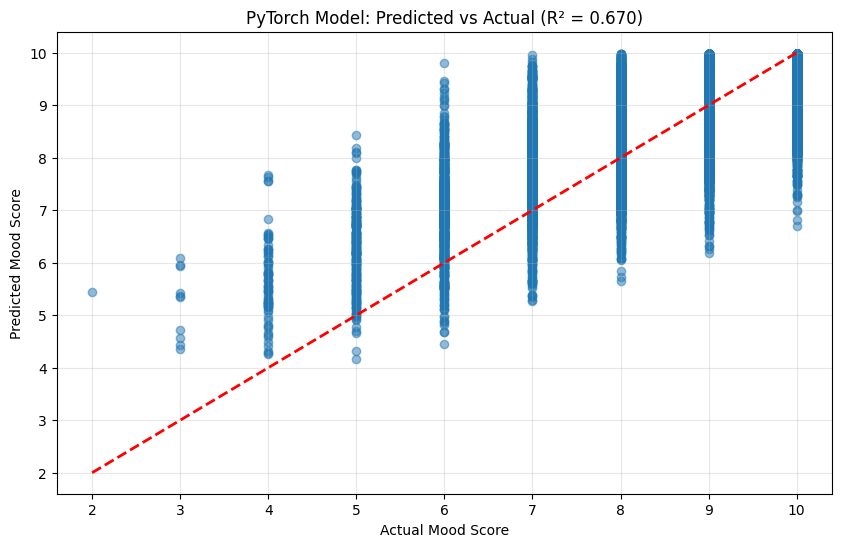

/tmp/ipython-input-2585567076.py:38: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `DL_Net([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DL_Net([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅

✅ PyTorch model exported to: /content/drive/MyDrive/DLnet_MentalHealth.onnx
ONNX predictions (first 5): [7.449828 9.106061 9.782848 9.563056 9.817227]
XGBoost Testing R²: 0.6675


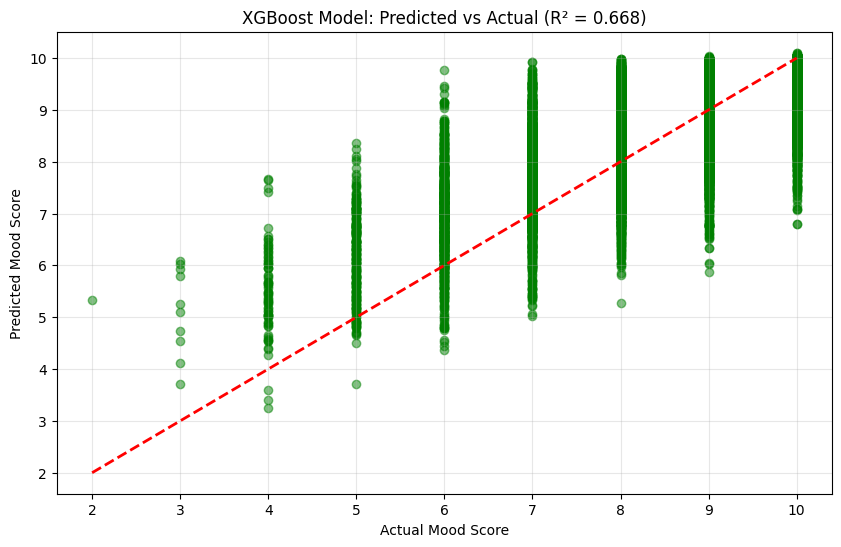


✅ XGBoost model exported to: /content/drive/MyDrive/xgboost_MentalHealth.onnx
XGBoost ONNX predictions (first 5): [[7.5503626]
 [8.987447 ]
 [9.763155 ]
 [9.28991  ]
 [9.723633 ]]

========== MODEL COMPARISON ==========
PyTorch R² : 0.6700
XGBoost R² : 0.6675


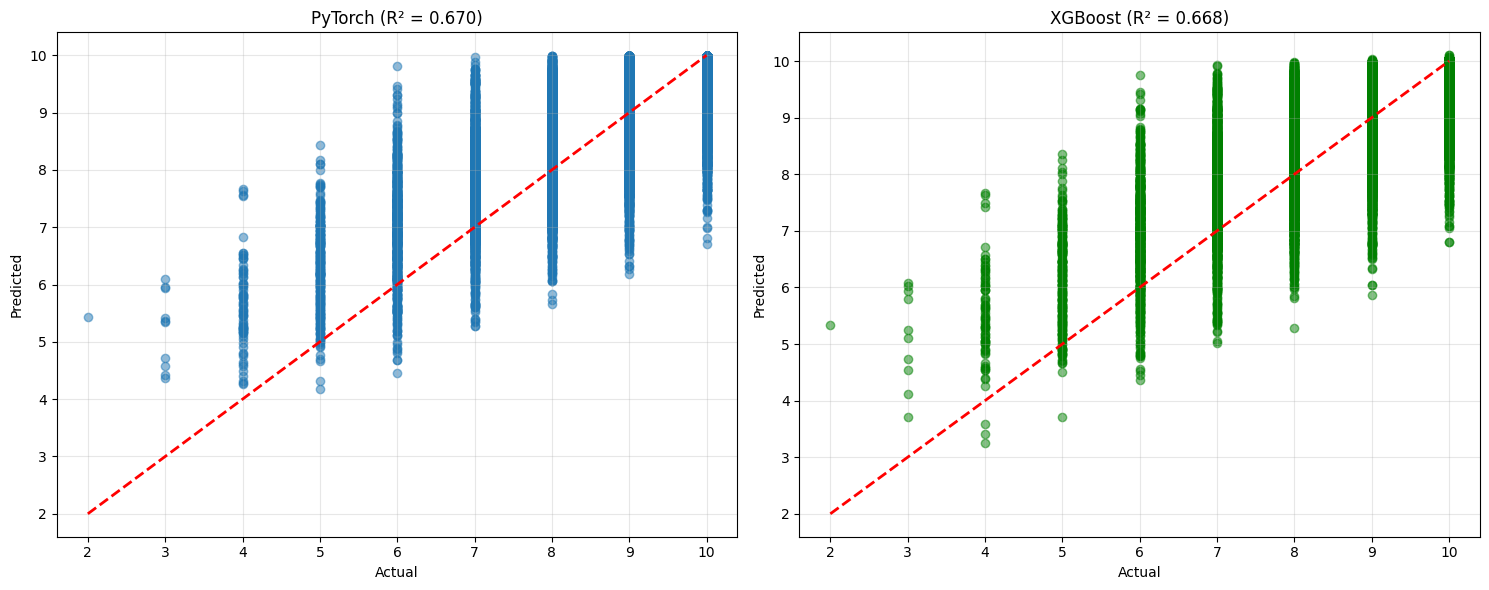


✅ All models trained, evaluated, and exported successfully!


In [37]:
# ============================================
# PART 1: EVALUATE PYTORCH MODEL
# ============================================

model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tr)

print("Prediction shape:", y_pred_test.shape)
print("Test data shape:", y_test_tr.shape)

r2 = r2_score(y_test_tr.numpy(), y_pred_test.numpy())
print(f"\nTesting R²: {r2:.4f}")

list_preds = y_pred_test.numpy().flatten().tolist()
list_reals = y_test_tr.numpy().flatten().tolist()

plt.figure(figsize=(10, 6))
plt.scatter(list_reals, list_preds, alpha=0.5)
plt.plot([min(list_reals), max(list_reals)],
         [min(list_reals), max(list_reals)],
         'r--', lw=2)
plt.xlabel('Actual Mood Score')
plt.ylabel('Predicted Mood Score')
plt.title(f'PyTorch Model: Predicted vs Actual (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# PART 2: DEPLOY PYTORCH MODEL TO ONNX (FIXED)
# ============================================

import onnxruntime as rt

dummy_input = torch.randn(1, 5)
pytorch_onnx_path = '/content/drive/MyDrive/DLnet_MentalHealth.onnx'

torch.onnx.export(
    model,
    dummy_input,
    pytorch_onnx_path,
    input_names=["input1"],
    output_names=["output1"],
    opset_version=18,
    dynamic_axes={
        "input1": {0: "batch_size"},
        "output1": {0: "batch_size"}
    }
)

print(f"\n✅ PyTorch model exported to: {pytorch_onnx_path}")

sess_pytorch = rt.InferenceSession(pytorch_onnx_path)
input_name_pt = sess_pytorch.get_inputs()[0].name
output_name_pt = sess_pytorch.get_outputs()[0].name

pred_onnx_pt = sess_pytorch.run(
    [output_name_pt],
    {input_name_pt: X_test[:5].astype(np.float32)}
)

print("ONNX predictions (first 5):", pred_onnx_pt[0].flatten())

# ============================================
# PART 3: TRAIN XGBOOST MODEL
# ============================================

import xgboost as xgb

regressor = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    gamma=0,
    reg_lambda=1
)

regressor.fit(X_train, y_train.ravel())

y_pred_xgb = regressor.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Testing R²: {r2_xgb:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual Mood Score')
plt.ylabel('Predicted Mood Score')
plt.title(f'XGBoost Model: Predicted vs Actual (R² = {r2_xgb:.3f})')
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# PART 4: DEPLOY XGBOOST MODEL TO ONNX (FIXED)
# ============================================

import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

booster = regressor.get_booster()

onnx_model = onnxmltools.convert_xgboost(
    booster,
    initial_types=[('input', FloatTensorType([None, 5]))]
)

xgboost_onnx_path = '/content/drive/MyDrive/xgboost_MentalHealth.onnx'
onnxmltools.utils.save_model(onnx_model, xgboost_onnx_path)

print(f"\n✅ XGBoost model exported to: {xgboost_onnx_path}")

sess_xgb = rt.InferenceSession(xgboost_onnx_path)
input_name_xgb = sess_xgb.get_inputs()[0].name
output_name_xgb = sess_xgb.get_outputs()[0].name

pred_ort_xgb = sess_xgb.run(
    [output_name_xgb],
    {input_name_xgb: X_test.astype(np.float32)}
)

print("XGBoost ONNX predictions (first 5):", pred_ort_xgb[0][:5])

# ============================================
# PART 5: COMPARE MODELS
# ============================================

print("\n========== MODEL COMPARISON ==========")
print(f"PyTorch R² : {r2:.4f}")
print(f"XGBoost R² : {r2_xgb:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(list_reals, list_preds, alpha=0.5)
ax1.plot([min(list_reals), max(list_reals)],
         [min(list_reals), max(list_reals)],
         'r--', lw=2)
ax1.set_title(f'PyTorch (R² = {r2:.3f})')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')
ax1.grid(True, alpha=0.3)

ax2.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
ax2.set_title(f'XGBoost (R² = {r2_xgb:.3f})')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predicted')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ All models trained, evaluated, and exported successfully!")


In [146]:
pip install xgboost==1.7.6


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [41]:
# ============================================
# NOTEBOOK DEPLOYMENT (SINGLE CELL - FINAL FIX)
# ============================================

import onnxruntime as rt
import numpy as np

# Load ONNX models
pt_sess = rt.InferenceSession('/content/drive/MyDrive/DLnet_MentalHealth.onnx')
xgb_sess = rt.InferenceSession('/content/drive/MyDrive/xgboost_MentalHealth.onnx')

pt_input = pt_sess.get_inputs()[0].name
pt_output = pt_sess.get_outputs()[0].name
xgb_input = xgb_sess.get_inputs()[0].name
xgb_output = xgb_sess.get_outputs()[0].name

# Deployment prediction function
def deploy_predict(data, model="pytorch"):
    X = np.array(data, dtype=np.float32)

    if model == "pytorch":
        return pt_sess.run([pt_output], {pt_input: X})[0].flatten()
    elif model == "xgboost":
        return xgb_sess.run([xgb_output], {xgb_input: X})[0]
    else:
        raise ValueError("model must be 'pytorch' or 'xgboost'")

# Simulated unseen deployment input
deployment_data = [
    [6.5, 3, 2, 7, 8],
    [4.0, 2, 1, 6, 6],
    [8.0, 4, 3, 5, 9]
]

# Run deployment inference
pt_preds = deploy_predict(deployment_data, "pytorch")
xgb_preds = deploy_predict(deployment_data, "xgboost")

# Display results (NO warnings)
for i, sample in enumerate(deployment_data):
    print(f"Input {i+1}: {sample}")
    print(f"  PyTorch ONNX Prediction : {pt_preds[i]:.3f}")
    print(f"  XGBoost ONNX Prediction : {xgb_preds[i][0]:.3f}")
    print("-" * 40)

print("✅ Deployment inference completed successfully")


Input 1: [6.5, 3, 2, 7, 8]
  PyTorch ONNX Prediction : 9.533
  XGBoost ONNX Prediction : 9.408
----------------------------------------
Input 2: [4.0, 2, 1, 6, 6]
  PyTorch ONNX Prediction : 9.549
  XGBoost ONNX Prediction : 9.411
----------------------------------------
Input 3: [8.0, 4, 3, 5, 9]
  PyTorch ONNX Prediction : 7.018
  XGBoost ONNX Prediction : 7.107
----------------------------------------
✅ Deployment inference completed successfully


In [44]:
# ============================================
# GRADIO WEB DEPLOYMENT WITH MOOD STATUS
# ============================================

!pip install -q gradio onnxruntime

import gradio as gr
import numpy as np
import onnxruntime as rt

# Load ONNX models
pt_sess = rt.InferenceSession('/content/drive/MyDrive/DLnet_MentalHealth.onnx')
xgb_sess = rt.InferenceSession('/content/drive/MyDrive/xgboost_MentalHealth.onnx')

pt_input = pt_sess.get_inputs()[0].name
pt_output = pt_sess.get_outputs()[0].name
xgb_input = xgb_sess.get_inputs()[0].name
xgb_output = xgb_sess.get_outputs()[0].name

# Mood status function
def get_mood_status(score):
    if score >= 8.5:
        return "😊 Good / Stable Mood"
    elif score >= 6.0:
        return "😐 Moderate Mood"
    else:
        return "⚠️ Low Mood / At Risk"

# Prediction function
def predict(screen_time, platforms, tiktok, sleep, stress):
    X = np.array([[screen_time, platforms, tiktok, sleep, stress]], dtype=np.float32)

    pt_out  = pt_sess.run([pt_output], {pt_input: X})[0]
    xgb_out = xgb_sess.run([xgb_output], {xgb_input: X})[0]

    pt_pred  = float(pt_out[0][0])
    xgb_pred = float(xgb_out[0][0])

    pt_status  = get_mood_status(pt_pred)
    xgb_status = get_mood_status(xgb_pred)

    return round(pt_pred, 3), pt_status, round(xgb_pred, 3), xgb_status

# Gradio Interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Number(label="Screen Time (hrs)"),
        gr.Number(label="Social Media Platforms"),
        gr.Number(label="Hours on TikTok"),
        gr.Number(label="Sleep Hours"),
        gr.Number(label="Stress Level")
    ],
    outputs=[
        gr.Number(label="PyTorch Mood Score"),
        gr.Textbox(label="PyTorch Mood Status"),
        gr.Number(label="XGBoost Mood Score"),
        gr.Textbox(label="XGBoost Mood Status")
    ],
    title="Mental Health Prediction System",
    description="Predict Mood Score and Mood Status using deployed ONNX models"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b677a41b58db9fcd71.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
